# Structured Information Extraction with `DDLite`

### Gene-Phenotype Relation Extraction Demonstration

In this demo, we'll be building a scalable machine learning & statistical inference-based information extraction system using an easy Jupyter Notebook interface.

We will attempt to extract _gene-phenotype relation mentions_ from the scientific literature; in other words, any time there is a phrase expressing a causal relationship between a mutation in some gene and a phenotype (symptom), such as:

> "A mutation in gene A is known to cause phenotype B"

We want to extract a tuple `(A,B)` for our knowledgebase.  We'll start by loading the `ddlite` library:

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)
import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ddlite import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing: Document & Sentence Parsing

In [3]:
dp          = DocParser('gene_phen_relation_example/data/', TextParser())
SAVED_SENTS = 'gene_phen_relation_example/gene_phen_saved_sents_v2.pkl'
try:
    sents = cPickle.load(open(SAVED_SENTS, 'rb'))
except:
    sents = dp.parseDocSentences()
    cPickle.dump(sents, open(SAVED_SENTS, 'w+'))

### Extracting candidate relation mentions

In [4]:
# Schema is: ENSEMBL_ID | NAME | TYPE (refseq, canonical, non-canonical)
GENE_DICT = 'gene_phen_relation_example/dicts/ensembl_genes.tsv'
genes = filter(lambda g : len(g) > 3, [line.rstrip().split('\t')[1] for line in open(GENE_DICT)])
GM = DictionaryMatch('G', genes, ignore_case=False)

# Schema is: HPO_ID | NAME | TYPE (exact, lemma)
PHENO_DICT = 'gene_phen_relation_example/dicts/pheno_terms.tsv'
phenos = [line.rstrip().split('\t')[1] for line in open(PHENO_DICT)]
PM = DictionaryMatch('P', phenos)

R  = Relations(sents, GM, PM)
CM = CandidateModel(R)

We can visualize contexts for our extractions too. This may help in writing labeling functions in a learning task.

In [6]:
R[2].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 Two neuropathies , Charcot-Marie-Tooth type 2A and autosomal dominant optic atrophy , are caused by mutations in essential fusion components , namely , mitofusin 2 or OPA1 .

In [ ]:
R._get_features().keys()[:10]

Finally, we can pickle the extracted candidates from our `Relations` object for later use.

In [7]:
with open('gene_phen_relation_example/medium_simple_holdout.pkl', 'rb') as f:
    CM.set_gold_labels(cPickle.load(f))
CM.set_holdout()

In [8]:
CM._current_mindtagger_samples = np.ravel(np.where(CM.get_ground_truth() != 0))
CM.open_mindtagger(width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


## Writing labeling functions
We'll use the **data programming method** to learn a logistic regression model which will predict the probability of a candidate entity being a true causal relationship. We'll start by writing labeling functions, or LFs. These are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example).

In [16]:
import re
import numpy as np

lfs = []

##### UTILS #####
def is_gene_parent(c, key):
    return key in [c.lemmas[c.dep_parents[i] - 1] for i in c.e1_idxs]
def pre_window(c, key, match='e1_idxs', n=3):
    s = list(c.__dict__[match])
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [c.lemmas[i] for i in s]
def post_window(c, key, match='e1_idxs', n=3):
    s = list(c.__dict__[match])
    b = len(c.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    return key in [c.lemmas[i] for i in s]
def span_len(c):
    return np.min(c.e2_idxs) - np.max(c.e1_idxs)
def stopper(c, stop, match='e1_idxs'):
    return stop in [c.lemmas[i] for i in c.__dict__[match]]

In [17]:
##### POSITIVE RULES #####

def lf_mutation(c):
    return 1 if is_gene_parent(c, 'mutation') else 0

def lf_deletion(c):
    return 1 if pre_window(c, 'deletion') else 0

def lf_loss(c):
    return 1 if pre_window(c, 'loss') else 0

def lf_short(c):
    return 1 if np.abs(span_len(c)) < 5 else 0

def lf_p_1(c):
    PATTERN_1 = re.compile(r"\{\{G\}\}(.*)(cause|responsible for)(.*)\{\{P\}\}")
    return 1 if PATTERN_1.search(c.tagged_sent) else 0

def lf_p_2(c):
    PATTERN_2 = re.compile(r"\{\{G\}\}(.*)in patients with(.*)\{\{P\}\}")
    return 1 if PATTERN_2.search(c.tagged_sent) else 0

def lf_p_3(c):
    PATTERN_3 = re.compile(r"\{\{P\}\}(.*)(caused by|due to|result of|attributable to)(.*)\{\{G\}\}")
    return 1 if PATTERN_3.search(c.tagged_sent) else 0

def lf_p_4(c):
    PATTERN_4 = re.compile(r"\{\{P\}\}results from(.*)\{\{G\}\}")
    return 1 if PATTERN_4.search(c.tagged_sent) else 0 

lfs.extend([lf_mutation, lf_deletion, lf_loss, lf_short, lf_p_1, lf_p_2, lf_p_3, lf_p_4])  

##### NEGATIVE RULES #####

def lf_long(c):
    return -1 if np.abs(span_len(c)) > 25 else 0

def lf_protein(c):
    return -1 if post_window(c, 'protein', n=2) else 0

def lf_express(c):
    return -1 if (post_window(c, 'express', n=2) or pre_window(c, 'express', n=2)) else 0

def lf_all(c):
    return -1 if stopper(c, 'all', 'e2_idxs') else 0

def lf_aut(c):
    return -1 if (' '.join([c.lemmas[i] for i in c.e2_idxs]).lower() == 'autosomal dominant') else 0

def lf_x(c):
    return -1 if (' '.join([c.lemmas[i] for i in c.e2_idxs]).lower() == 'x-linked') else 0   
    
def lf_p_5(c):
    PATTERN_5 = re.compile(r"\{\{G\}\}(.*)(whereas|however|not)(.*)\{\{P\}\}")
    return -1 if PATTERN_5.search(c.tagged_sent) else 0

def lf_p_6(c):
    PATTERN_6 = re.compile(r"\{\{P\}\}(.*)(whereas|however|not)(.*)\{\{G\}\}")
    return -1 if PATTERN_6.search(c.tagged_sent) else 0

def lf_p_7(c):
    PATTERN_7 = re.compile(r"\{\{G\}\}(.*)not(.*)cause(.*)\{\{P\}\}")
    return -1 if PATTERN_7.search(c.tagged_sent) else 0

def lf_p_8(c):
    PATTERN_8 = re.compile(r"\{\{P\}\}(.*)not(.*)cause(.*)\{\{G\}\}")
    return -1 if PATTERN_8.search(c.tagged_sent) else 0

def lf_p_9(c):
    PATTERN_9 = re.compile(r"unlikely(.*)\{\{G\}\}(.*)\{\{P\}\}")
    return -1 if PATTERN_9.search(c.tagged_sent) else 0

def lf_p_10(c):
    PATTERN_10 = re.compile(r"\{\{P\}\}(.*)not due to(.*)\{\{G\}\}")
    return -1 if PATTERN_10.search(c.tagged_sent) else 0

lfs.extend([lf_long, lf_protein, lf_express, lf_all, lf_aut, lf_x, lf_p_5, lf_p_6, lf_p_7, lf_p_8])  

In [18]:
CM.apply_lfs(lfs, clear=True)

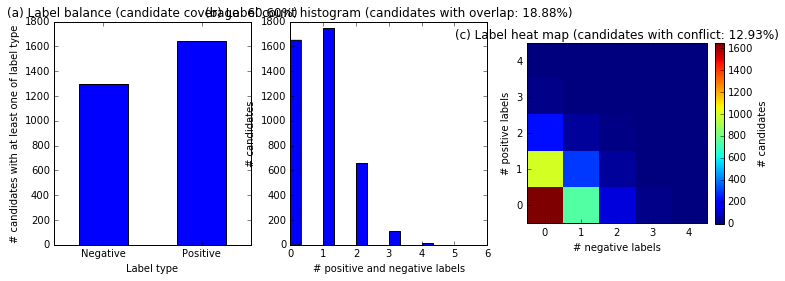

In [19]:
CM.plot_lf_stats()

In [20]:
CM.top_conflict_lfs(n=5)

Labeling function,Fraction of candidates where LF has conflict
lf_aut,0.001
lf_p_1,0.000
lf_p_3,0.000
lf_long,0.000
lf_short,0.000


In [21]:
CM.lowest_coverage_lfs(n=5)

Labeling function,Fraction of abstained votes
lf_p_4,1.000
lf_p_8,0.999
lf_p_7,0.999
lf_express,0.997
lf_loss,0.997


In [22]:
CM.lowest_empirical_accuracy_lfs(n=20)

Labeling function,Empirical LF accuracy
lf_p_4,0.000 (n=0)
lf_aut,0.556 (n=9)
lf_long,0.558 (n=43)
lf_p_5,0.600 (n=10)
lf_p_1,0.661 (n=124)
lf_p_3,0.721 (n=68)
lf_short,0.733 (n=15)
lf_mutation,0.746 (n=71)
lf_p_2,0.750 (n=12)
lf_loss,1.000 (n=1)


Running test fold 0
Running test fold 1
Running test fold 2


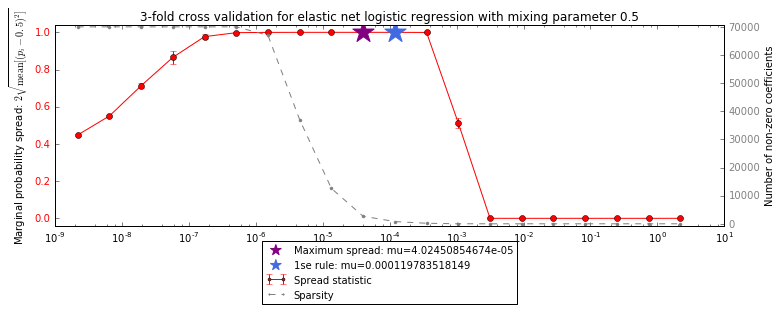

CPU times: user 19min 32s, sys: 6.47 s, total: 19min 39s
Wall time: 19min 39s


<ddlite.ModelLog instance at 0x12e086320>

In [23]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time CM.learn_weights(tol=1e-3, sample=True, maxIter=2500, n_mu=20, mu_min_ratio=1e-9, alpha=0.5, opt_1se=True, verbose=True, plot=True, log=True)

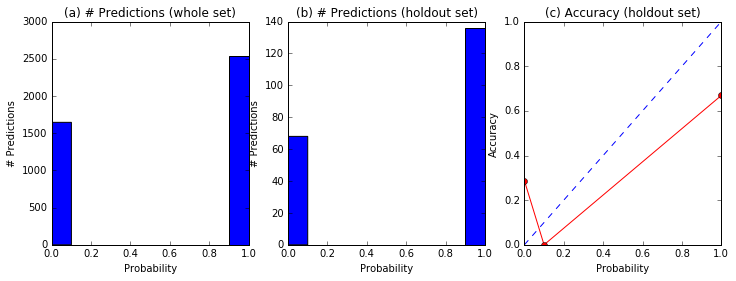

In [26]:
CM.plot_calibration()

In [25]:
print "Number of non-zero weights: {}".format(np.sum(np.abs(CM.w) > 1e-12))

Number of non-zero weights: 807
